- stacked chart of player origin
- histogram of elo in a tournament
- histogram of playing time (need to transfer from string first)


In [1]:
import bga_function  #(self-made functions)
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import statistics
import datetime
import re
import pandas as pd
import numpy as np
import holoviews as hv
import hvplot.pandas # adds hvplot method to pandas objects
from selenium.webdriver.common.action_chains import ActionChains
from contextlib import redirect_stdout
from bokeh.plotting import show
from bokeh.io import export_png
import os
# from selenium.webdriver.chrome.options import Options
waiting_time = 5

In [2]:
# service = webdriver.FirefoxService(executable_path = r'C:\Users\Simon\app\bin\geckodriver.exe')
# driver = webdriver.Firefox(service=service)
# "C:\Users\Simon\Documents\GitHub\wpoc\code\chromedriver.exe"
# service = webdriver.ChromeService(executable_path = r'C:\Users\Simon\Documents\GitHub\wpoc\code\chromedriver.exe')
service = webdriver.ChromeService(executable_path = r'C:\Users\chia-jung.s\Documents\GitHub\wpoc\code\chromedriver.exe')
driver = webdriver.Chrome(service=service)
driver.get("https://en.boardgamearena.com/account")
time.sleep(waiting_time)

In [3]:
clickable1 = driver.find_element(By.ID, "username_input")
ActionChains(driver).click(clickable1).send_keys("simbkt").perform()
clickable2 = driver.find_element(By.ID, "password_input")
ActionChains(driver).click(clickable2).send_keys("qwerasdf").perform()
time.sleep(waiting_time)
clickable3 = driver.find_element(By.ID, "submit_login_button")
ActionChains(driver).click(clickable3).perform()
time.sleep(waiting_time)

### Scrap tournament page: get game name, user name and link, match link


In [4]:
driver.get("https://boardgamearena.com/tournament?id=320480")

In [5]:
# get url of this tournament
tournament_link = driver.current_url
# get tournament name
tournament_name = driver.find_element(By.CLASS_NAME, 'tournaments-presentation__title-tournament').text
print(tournament_name)
# get game name
game_name = driver.find_element(By.CLASS_NAME, 'tournaments-presentation__title-game').find_element(By.CLASS_NAME, 'bga-link').text
print(game_name)
print(tournament_link)
# get start date
start_date = driver.find_element(By.CLASS_NAME, 'localDate').text[:10]
# get lists of names and link from the  tournament page; either finished, planned, ongoing 
entries_finished_tournament = driver.find_elements(By.CLASS_NAME, 'tournaments-results-players__name')
preliminary_entries = driver.find_elements(By.CLASS_NAME, 'tournaments-registered-players__player ')
entries_ongoing_tournament = []
for i in preliminary_entries:
    if i.find_element(By.CLASS_NAME, 'tournaments-registered-players__rank').text == 'invited':
        pass
    else:
        entries_ongoing_tournament.append(i.find_element(By.CLASS_NAME, 'tournaments-registered-players__name'))
# get a list of ranked players
ranked_player = []
if game_name == '7 Wonders': # special process for 7 wonders without second stage
    top_rank_class = ['tournaments-results-players__player--rank1',
                      'tournaments-results-players__player--rank2',
                      'tournaments-results-players__player--rank3',
                      'tournaments-results-players__player--rank4',
                      'tournaments-results-players__player--rank5',
                      'tournaments-results-players__player--rank6',
                      'tournaments-results-players__player--rank7',
                      'tournaments-results-players__player--rank8']
else:  # # general process for games with second stages
    top_rank_class = ['tournaments-results-players__player--rank1','tournaments-results-players__player--rank2','tournaments-results-players__player--rank3','tournaments-results-players__player--rank5']
for i in top_rank_class:
    entries = driver.find_elements(By.CLASS_NAME, i)
    for _ in entries:
        result = re.findall("(.*)\n(.*)",_.text)
        link = _.find_element(By.CLASS_NAME, "playername").get_attribute('href')
        ranked_player.append([result,link])
# get a list of all players    
players=[]
player_links=[]
tables=[]
for i in entries_finished_tournament + entries_ongoing_tournament: # print results while running
    players.append(i.text)
    player_links.append(i.get_attribute("href"))
print(f"number of players: {len(players)}") 

if driver.find_element(By.CLASS_NAME,'tournaments-mode-presentation__name').text !='Groups Stage': #tournament other than group stage
    entries_table = driver.find_elements(By.CLASS_NAME, 'v2tournament__encounter-title')
    for i in entries_table:
        if i.text == 'Skipped': # dont include ongoing tables
            pass
        else:
            tables.append(i.get_attribute("href"))
else: # group stage tournament 
    group_page_link = []
    for i in driver.find_elements(By.CLASS_NAME,'v2tournament__encounter-title'):
        group_page_link.append(i.get_attribute("href"))
    for link in group_page_link:
        if re.search("tournament",link): # stage 1 group link
            print("look into the page of a group...")
            driver.get(link)
            time.sleep(waiting_time)
            entries_table = driver.find_elements(By.CLASS_NAME, 'v2tournament__encounter-title')
            for i in entries_table:
                if i.text == 'Skipped': # dont include ongoing tables
                    # print("skipped")
                    pass
                else:
                    tables.append(i.get_attribute("href")) 
        else: # stage 2 elimination table links
            tables.append(link)     
tables = list(filter(None, tables)) # get rid of entries of skipped tables
print("number of tables:", len(tables))
# initialize the interrupt flag
interrupt = -1

Western Pacific Ocean Cup • Season 4
Carcassonne
https://boardgamearena.com/tournament?id=320480
number of players: 80
look into the page of a group...
look into the page of a group...
number of tables: 247


## Scrap user page: retrun the information of users


In [6]:
# diagnosis code when interrupted
interrupt += 1
if interrupt == 0: # command to start new task
    pass
else:
    pos = len(player_info) 
    print("number of iteration left: ",len(players)-pos)
    waiting_time += 1

In [7]:
# estimate script running time
scrip_player_duration = len(players) * waiting_time * 1.43    #tried 1.4 1.5 1.45 1.43 
script_player_time = datetime.datetime.now() + datetime.timedelta(seconds=scrip_player_duration)
print(f"estimate to finish scraping players at {script_player_time.strftime('%H:%M')}")

# visit every user page
if interrupt == 0: # command to start new task
    player_info = []
    for i in range(len(players)): # loop into each player's user page
        player_info.append(bga_function.get_player_info(driver, waiting_time, player_links[i], game_name))
        print(len(player_info), end=" ")
else: # command when interrupt
    for i in range(pos, len(players)): # when interrupt
        player_info.append(bga_function.get_player_info(driver, waiting_time, player_links[i], game_name))
        print(len(player_info), end=" ")

print(f"finish scraping players at {datetime.datetime.now().strftime('%H:%M')}")    

estimate to finish scraping players at 08:35
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 finish scraping players at 08:38


In [8]:
# print("number of iteration left: ",len(players) - len(player_info) )

In [9]:
countries = []
elos = []
languages = []
reputations = []
# read the data
for i in player_info:
    if i[0] == '':
        pass
    else:
        countries.append(i[1].split(",")[0])
        elos.append(i[2])
        languages.append(i[3])
        reputations.append(i[4])
# get Q1, Q2,Q3
elos = [int(i) for i in elos] # convert string to value  in elos
elo_q1 = int(np.quantile(elos, .25))
elo_q2 = int(np.quantile(elos, .5))
elo_q3 = int(np.quantile(elos, .75))
# get top origins of players
top_countries = (pd.DataFrame(countries).value_counts() /len(countries) *100).astype('int').astype('str') +'%'
# make plot of elo distribution
df1 = pd.DataFrame(elos, columns=['elo'])
df1['dummy'] = 1
plot = hv.BoxWhisker(df1, vdims='elo')  * df1.hvplot.scatter(y='elo' ,x = 'dummy', c='orange', size = 5).opts(jitter=0.3)
plot.opts(invert_axes=True, height = 70, width=350, xlabel='',ylabel='', title ='Elo of players',yaxis = None, fontsize={'title': 11})
fig = hv.render(plot)
fig.outline_line_width = 0
fig.toolbar.autohide = True
show(fig)
# save into png and make transparent background
elo_file = '../assets/images/' + game_name + tournament_name +"_Elo_" + time.strftime("%Y%m%d%H%M%S", time.localtime()) + '.png'
export_png(fig, filename = elo_file)
print('output:', elo_file)
# make transparaennt background and delete the original file
transformed_elo_file = bga_function.transparent_background(elo_file)
os.remove(elo_file)
# list players with local origins
watch_list =['South Korea','North Korea','Japan',
             'China','Hong Kong','Macao','Taiwan',
             'Singapore','Viet Nam','Thailand','Indonesia','Malaysia','Philippines','Myanmar','Cambodia',
             'India','Bangladesh','Pakistan',
             'Kazakhstan','Mongolia','Georgia',
             'Australia','New Zealand','Palau']
index_list = []
index = 0
for i in countries:
    if i in watch_list:
        # print(count,i)
        index_list.append(index)
    else:
        pass
    index +=1
# output information into the file
with open(game_name + ' - ' +tournament_name + '.txt', "w", encoding='utf-8') as f:
    with redirect_stdout(f):
        print("---LocalPlayer---\n")
        for i in index_list:
            # print(players[i])
            print(players[i]) if int(reputations[i].strip("%")) >= 85 else None
        print("\n- Reputations:\n")
        for i in index_list:
            print(players[i], "-",reputations[i])
        print("\n\n---link of user page---\n")
        for i in index_list:
            print(player_links[i])
        print("\n---Origin---\n")
        for i in index_list:
            print(countries[i])
            # print("\n")
        print("\n---Language---\n")
        for i in index_list:
            print(', '.join(languages[i]))
            # print("\n")
        print("\n\n- Origins of players:\n")
        print(top_countries)
        print("\n\n\n- Q1/Q2/Q3 of player's Elo rating:\n")
        print(f"{elo_q1}/{elo_q2}/{elo_q3}")
f.close()
### finish scraping player data
print("finished time: ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

output image: ../assets/images/CarcassonneWestern Pacific Ocean Cup • Season 4_Elo_20241119083813.png
output image: ../assets/images/t_CarcassonneWestern Pacific Ocean Cup • Season 4_Elo_20241119083813.png
2024-11-19 08:38:18


## read the list of tables, return table duration and slow players:

In [10]:
# initialize the interrupt flag
interrupt = -1
time.sleep(waiting_time)

In [11]:
### diagnosis code when interrupted
interrupt += 1
if interrupt == 0: # command to start new task
    scrip_table_duration = len(tables) * waiting_time * 1.5
else: #interrupt not equal to 0
    pos = len(table_info) 
    print("number of iteration left: ",len(tables)-pos)
    waiting_time += 1
    scrip_table_duration = (len(tables)-pos) * waiting_time * 1.5

In [12]:
# loop into all tables
# estimate time needed
print("number of tables:", len(tables))
script_table_time = datetime.datetime.now() + datetime.timedelta(seconds=scrip_table_duration)
print(f"estimate to finish scraping tables at {script_table_time.strftime('%H:%M')}")

if interrupt == 0: # when scraping for the first time
    table_info = []
    for i in range(len(tables)):
        table_info.append(bga_function.get_table_info(driver, waiting_time,tables[i]))
        print(len(table_info), end=" ")
else: # when interrupt not equal to 0
    for i in range(pos, len(tables)): 
        table_info.append(bga_function.get_table_info(driver, waiting_time,tables[i]))
        print(len(table_info), end=" ")

estimate to finish scraping tables at 09:09
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 

In [13]:
# print("number of iteration left: ",len(tables)-len(table_info))

number of iteration left:  0


In [14]:
# list players that is either too slow or leave the game intentionly
black_list = []
for i in table_info:
    if i[3] != '': # leave or kicked
        black_list.append(i[3]) 
    elif i[4] != '':  # didnt finish on time
        black_list.append(i[4]) 

# append the black list to the file
f = open(game_name + ' - ' +tournament_name + '.txt', "a", encoding='utf-8')
f.write("\n---BlackList---\n\n") 
for i in black_list:
    f.write(i)
    f.write("\n")
f.close()

In [15]:
# statistics"""'
number_tables = len(tables)
ratio_cancelled_tables = 0
for i in range(len(table_info)):
    # print(table_info[i][0])
    ratio_cancelled_tables += 1/number_tables if table_info[i][0] == 'cancelled' else 0

ratio_abandoned_tables = 0
for i in range(len(table_info)):
    ratio_abandoned_tables +=1/number_tables if table_info[i][0] == 'abandoned' else 0    
    
table_times = []
for i in range(len(table_info)):
    table_times.append(table_info[i][1])

# create df with player name and time spent
df = pd.DataFrame(columns = ['Player', 'Used_time'])
for i in range(len(table_info)):
    players_time = table_info[i][2] 
    for i in players_time:
        dict = {'Player':[i[0]], 
                'Used_time':[i[1]] 
               } 
        df_add = pd.DataFrame(dict) 
        df = pd.concat([df, df_add], ignore_index = True) 

# convert the unit of duration into days
converted_table_times = bga_function.time_converstion(table_times)
# spread statistics
median_duration = round(statistics.median(converted_table_times),1)
duration_q1 = (np.quantile(converted_table_times, .25))
duration_q2 = (np.quantile(converted_table_times, .5))
duration_q3 = (np.quantile(converted_table_times, .75))
print("Q1/Q2/Q3 quantile of time: ", duration_q1,duration_q2,duration_q3)
# output to the file
f = open(game_name + ' - ' +tournament_name + '.txt', "a", encoding='utf-8')
f.write("\n-----\nQ1/Q2/Q3 quantile of time: \n")
f.write(str(duration_q1) + ", "+str(duration_q2) + ", "+ str(duration_q3)) 
f.write("\n")
f.close()

Q1/Q2/Q3 quantile of time:  1.0 2.2 5.0


In [16]:
# plot
from bokeh.plotting import show
from bokeh.io import export_png
df2 = pd.DataFrame(converted_table_times, columns=['tt'])
df2['dummy'] = 1
plot = hv.BoxWhisker(df2, vdims='tt')  * df2.hvplot.scatter(y='tt' ,x = 'dummy', c='orange', size=5).opts(jitter=0.3)
plot.opts(invert_axes=True, height = 70, width=350, xlabel='',ylabel='', yaxis=None, title='Table duration (days)',fontsize={'title': 11})
fig = hv.render(plot)
fig.outline_line_width =0
fig.toolbar.autohide = True
show(fig)
# save into png and make transparent background
duration_file = '../assets/images/'+ game_name + tournament_name + "_Duration_" +time.strftime("%Y%m%d%H%M%S", time.localtime()) + '.png'
export_png(fig, filename=duration_file)
print('output image:', duration_file)
transformed_duration_file = bga_function.transparent_background(duration_file)
os.remove(duration_file)

output image: ../assets/images/CarcassonneWestern Pacific Ocean Cup • Season 4_Duration_20241119090806.png
output image: ../assets/images/t_CarcassonneWestern Pacific Ocean Cup • Season 4_Duration_20241119090806.png


In [17]:
### finish table part
print(f"- Abandoned tables (reached duration limit): {ratio_abandoned_tables:.0%}")
print(f"- Cancelled tables (player left or got kicked): {ratio_cancelled_tables:.0%}")
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
time.sleep(waiting_time)

- Abandoned tables (reached duration limit): 14%
- Cancelled tables (player left or got kicked): 6%
2024-11-19 09:08:08


## summary

In [21]:
# summary message
print(f"- [{tournament_name.replace("Western Pacific Ocean Cup • ","")}]({tournament_link})")
print("- Date:",start_date, "- __/__/2024") #put this manually 
print('- Number of players:', len(players))
print("- Top origins of players:",top_countries.index[0][0], f"{top_countries.iloc[0]}", top_countries.index[1][0], f"{top_countries.iloc[1]}", top_countries.index[2][0], f"{top_countries.iloc[2]}", top_countries.index[3][0], f"{top_countries.iloc[3]}", top_countries.index[4][0], f"{top_countries.iloc[4]}") 
print(f"- Abandoned tables (reached duration limit): {ratio_abandoned_tables:.0%}")
print(f"- Cancelled tables (player left or got kicked): {ratio_cancelled_tables:.0%}")
print("- Q1/Q2/Q3 of player's Elo rating:", f"{elo_q1}/{elo_q2}/{elo_q3}")
print("- Q1/Q2/Q3 of table duration (days):", f"{round(duration_q1,1)}/{round(duration_q2,1)}/{round(duration_q3,1)}") 
# print('- Winners:', f"\U0001F947{players[0]}", f"\U0001F948{players[1]}", f"\U0001F949{players[2]}")
print("- Winners(meta event points):", 
    f'{ranked_player[0][0][0][0]}(100);', 
    f'{ranked_player[1][0][0][0]}(75);',
    f'{ranked_player[2][0][0][0]}(50);',
    f'{ranked_player[3][0][0][0]}(50);',
    f'{ranked_player[4][0][0][0]}(10);',    
    f'{ranked_player[5][0][0][0]}(10);',
    f'{ranked_player[6][0][0][0]}(10);',
    f'{ranked_player[7][0][0][0]}(10)',)
# image links
print("")
print('<div>')
print(' <img src="/wpoc/assets/images/tournament/', re.findall('assets/images/(.*)',transformed_elo_file)[0],'" width="300" style="display: block; margin-left: 30px; margin-bottom: 5px; margin-top:-15px"/>', sep='')
print('</div>')
print('<div>')
print(' <img src="/wpoc/assets/images/tournament/', re.findall('assets/images/(.*)',transformed_duration_file)[0],'" width="300" style="display: block; margin-left: 30px; margin-bottom: 5px;"/>', sep='')
print('</div>')
# print("")
print('<p>&nbsp;</p>')
# Things to check manually
print("\n\n1. check last day of tournament from the tournament page")
print("2. change the 4th player point to 25")
print("3. update Region standings of one specific game")
print("4. update Region standings of sum of all game")
print("5. move the elo and table duration figure to the corresponing folder")

- [Season 4](https://boardgamearena.com/tournament?id=320480)
- Date: 09/30/2024 - __/__/2024
- Number of players: 80
- Top origins of players: Japan 11% Russia 11% Australia 7% France 7% Germany 6%
- Abandoned tables (reached duration limit): 14%
- Cancelled tables (player left or got kicked): 6%
- Q1/Q2/Q3 of player's Elo rating: 164/302/485
- Q1/Q2/Q3 of table duration (days): 1.0/2.2/5.0
- Winners(meta event points): webbi(100); Grizli1981(75); tEmNiy(50); Carquinyolis(50); spman2(10); kurikinton1124(10); maticarrizoc(10); Tarakanov28(10)

<div>
 <img src="/wpoc/assets/images/tournament/t_CarcassonneWestern Pacific Ocean Cup • Season 4_Elo_20241119083813.png" width="300" style="display: block; margin-left: 30px; margin-bottom: 5px; margin-top:-15px"/>
</div>
<div>
 <img src="/wpoc/assets/images/tournament/t_CarcassonneWestern Pacific Ocean Cup • Season 4_Duration_20241119090806.png" width="300" style="display: block; margin-left: 30px; margin-bottom: 5px;"/>
</div>
<p>&nbsp;</p>




# Player_ranking

In [19]:
# add region information to ranked players
for item in ranked_player:
    player_region = bga_function.get_player_info(driver, waiting_time, item[1], game_name)[1]
    item.append(player_region)

In [20]:
print("2. paste information below to csv:")
print(">>\n")
        # countries.append(i[1].split(",")[0])

for item in ranked_player:
    # print(item[0][0][1])
    # print(game_name,",", tournament_name.replace("Western Pacific Ocean Cup • ",""),"," ,item[0][0][0], ",", item[2],",",item[0][0][1], sep='')    
    print(game_name,",", 
          tournament_name.replace("Western Pacific Ocean Cup • ",""),"," ,
          item[0][0][0], ",", 
          item[2].split(",")[0],",",
          item[0][0][1].replace("1st", "100").replace("2nd", "75").replace("3rd", "50").replace("4th", "25") \
          .replace("5th", "10").replace("6th", "10").replace("7th", "10").replace("8th", "10"), 
          sep='')    
# for item in ranked_player:
#     print("All Games",",", tournament_name.replace("Western Pacific Ocean Cup • ",""),"," ,item[0][0][0], ",", item[2],",", item[0][0][1], sep='')

2. paste information below to csv:
>>

Carcassonne,Season 4,webbi,Argentina,100
Carcassonne,Season 4,Grizli1981,Ukraine,75
Carcassonne,Season 4,tEmNiy,Russia,50
Carcassonne,Season 4,Carquinyolis,Palau,50
Carcassonne,Season 4,spman2,Japan,10
Carcassonne,Season 4,kurikinton1124,Japan,10
Carcassonne,Season 4,maticarrizoc,Argentina,10
Carcassonne,Season 4,Tarakanov28,Russia,10


C:\Users\chia-jung.s\Documents\GitHub\wpoc\code\bga_function.py:258: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/TheCastlesofBurgundyRanking.png
The Castles of Burgundy
🥇China(175) 🥈Poland(50) 🥉United States of America(50)
Region
China                       175
Poland                       50
United States of America     50
Russia                       10
Spain                        10
Taiwan                       10
Ukraine                      10
Name: MetaPoint, dtype: int64


C:\Users\chia-jung.s\Documents\GitHub\wpoc\code\bga_function.py:258: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/ForestShuffleRanking.png
Forest Shuffle
🥇France(135) 🥈Czechia(100) 🥉Sweden(100)
Region
France         135
Czechia        100
Sweden         100
Belgium         75
Thailand        60
Australia       50
New Zealand     50
Russia          20
Austria         10
Canada          10
Germany         10
Japan           10
Name: MetaPoint, dtype: int64


C:\Users\chia-jung.s\Documents\GitHub\wpoc\code\bga_function.py:258: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/TickettoRideRanking.png
Ticket to Ride
🥇Spain(160) 🥈France(110) 🥉Netherlands(100)
Region
Spain                       160
France                      110
Netherlands                 100
Hong Kong                    95
Australia                    85
United States of America     50
United Kingdom               20
China                        10
Name: MetaPoint, dtype: int64


C:\Users\chia-jung.s\Documents\GitHub\wpoc\code\bga_function.py:258: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/7WondersRanking.png
7 Wonders
🥇Belgium(160) 🥈Germany(145) 🥉Japan(100)
Region
Belgium                     160
Germany                     145
Japan                       100
Netherlands                 100
Poland                       85
Hong Kong                    75
Hungary                      75
France                       25
Philippines                  25
United States of America     20
Australia                    10
Canada                       10
Italy                        10
Taiwan                       10
Ukraine                      10
Viet Nam                     10
Name: MetaPoint, dtype: int64


C:\Users\chia-jung.s\Documents\GitHub\wpoc\code\bga_function.py:258: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/SplendorRanking.png
Splendor
🥇Japan(455) 🥈China(190) 🥉South Korea(125)
Region
Japan          455
China          190
South Korea    125
France          85
Hong Kong       50
Netherlands     20
Canada          10
Taiwan          10
Name: MetaPoint, dtype: int64


C:\Users\chia-jung.s\Documents\GitHub\wpoc\code\bga_function.py:258: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/WingspanRanking.png
Wingspan
🥇France(175) 🥈Australia(160) 🥉United States of America(160)
Region
France                      175
Australia                   160
United States of America    160
Germany                     100
Hong Kong                   100
Peru                         70
Taiwan                       60
Kazakhstan                   50
Belgium                      10
China                        10
Hungary                      10
Japan                        10
Mexico                       10
Ukraine                      10
Viet Nam                     10
Name: MetaPoint, dtype: int64


C:\Users\chia-jung.s\Documents\GitHub\wpoc\code\bga_function.py:258: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/KingdominoRanking.png
Kingdomino
🥇Poland(310) 🥈France(145) 🥉United States of America(125)
Region
Poland                      310
France                      145
United States of America    125
Spain                       110
Canada                       85
New Zealand                  50
Viet Nam                     50
Australia                    20
Switzerland                  20
Greece                       10
Japan                        10
Taiwan                       10
Name: MetaPoint, dtype: int64


C:\Users\chia-jung.s\Documents\GitHub\wpoc\code\bga_function.py:258: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/CarcassonneRanking.png
Carcassonne
🥇Japan(205) 🥈Taiwan(160) 🥉Argentina(160)
Region
Japan                  205
Taiwan                 160
Argentina              160
Philippines            150
Palau                  125
Russia                 110
Mexico                 100
Ukraine                 85
Thailand                75
France                  10
Czechia                 10
Panama                  10
Chile                   10
Poland                  10
Brazil                  10
Spain                   10
Australia               10
Antigua and Barbuda     10
Name: MetaPoint, dtype: int64


C:\Users\chia-jung.s\Documents\GitHub\wpoc\code\bga_function.py:258: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/AzulRanking.png
Azul
🥇China(245) 🥈France(170) 🥉Japan(170)
Region
China          245
France         170
Japan          170
Holy See       100
Philippines    100
Australia       80
Hong Kong       50
Thailand        20
Italy           10
Name: MetaPoint, dtype: int64


C:\Users\chia-jung.s\Documents\GitHub\wpoc\code\bga_function.py:258: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/AllGamesRanking.png
All Games
🥇Japan(960) 🥈France(855) 🥉China(630)
Region
Japan                       960
France                      855
China                       630
Poland                      455
Australia                   415
United States of America    405
Hong Kong                   370
Spain                       290
Philippines                 275
Taiwan                      260
Germany                     255
Belgium                     245
Netherlands                 220
Argentina                   160
Thailand                    155
Russia                      140
South Korea                 125
Palau                       125
Canada                      115
Ukraine                     115
Mexico                      110
Czechia                     110
New Zealand                 100
Sweden                      100
Holy See                    100
Hungary                      85
Viet Nam                     70
Peru                         70
Kazak

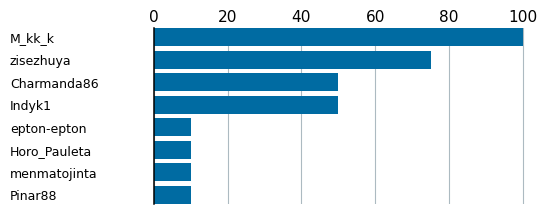

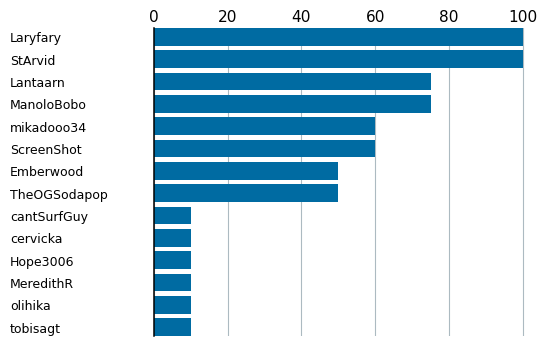

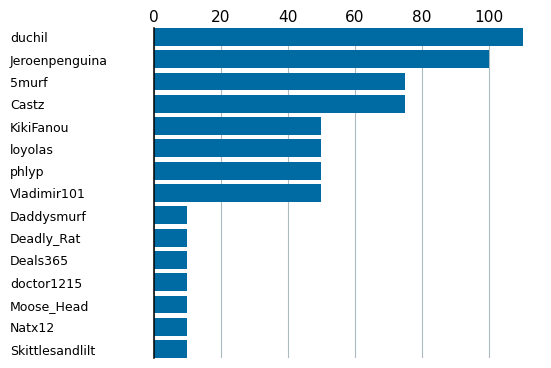

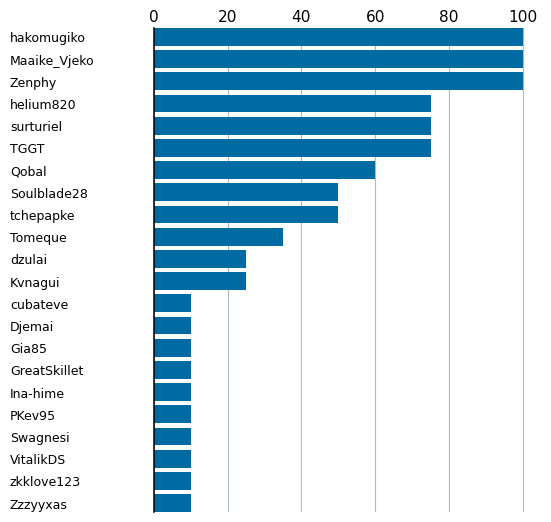

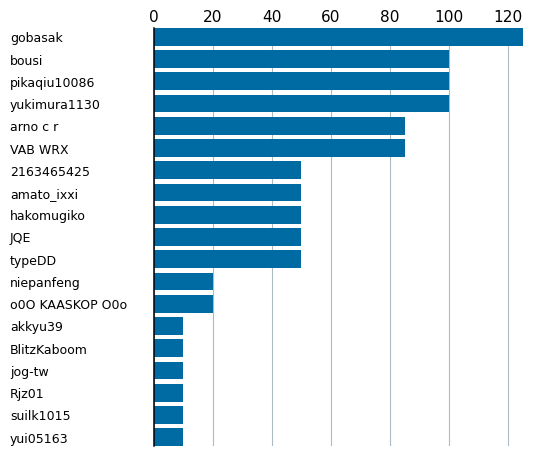

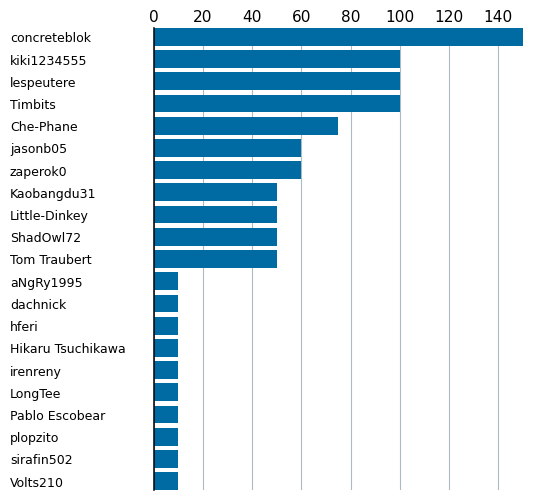

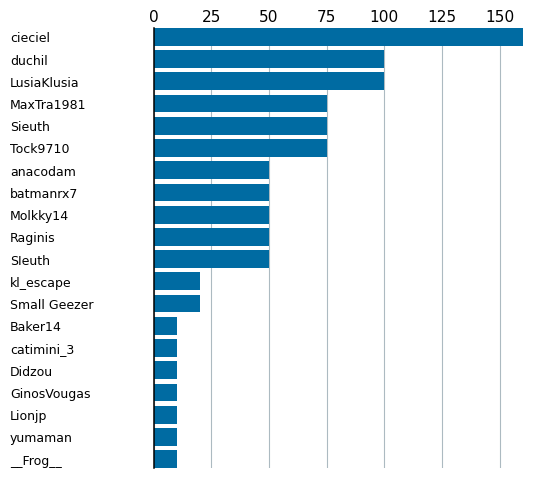

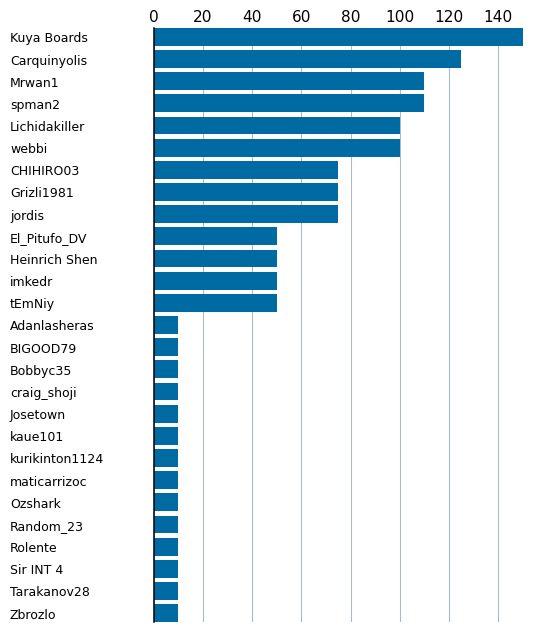

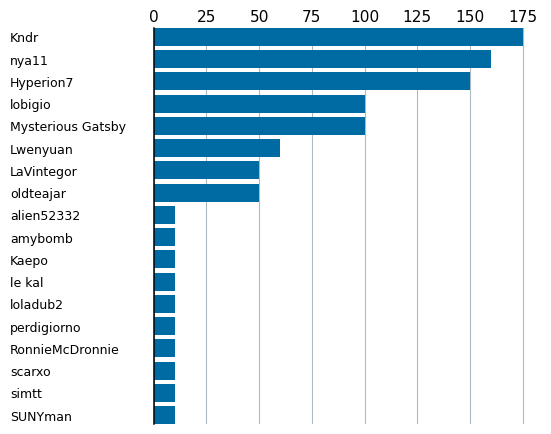

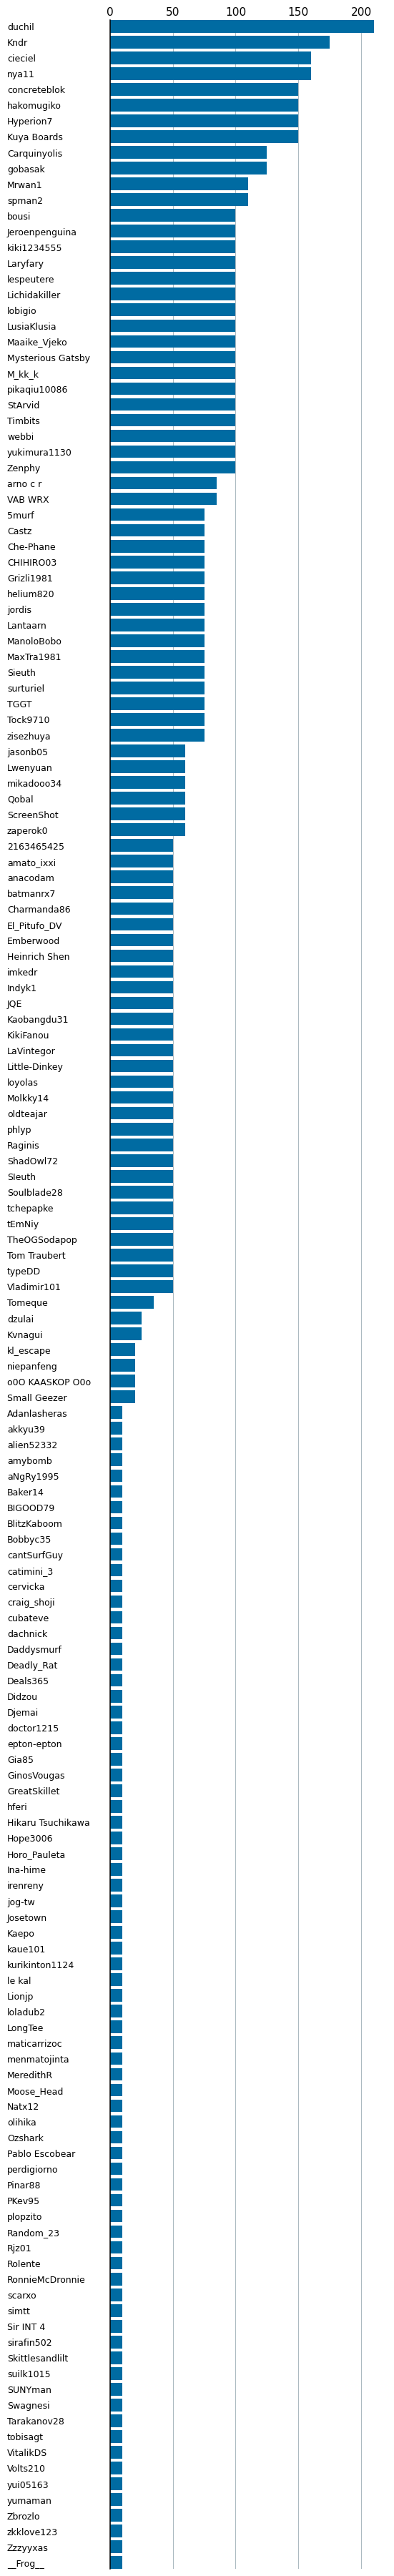

In [22]:
# after update the csv file, output the graph
import bga_function  #(self-made functions)
import time
for GameName in ['The Castles of Burgundy','Forest Shuffle','Ticket to Ride', '7 Wonders','Splendor', 'Wingspan', 'Kingdomino','Carcassonne', 'Azul','All Games']:
    # bga_function.PlayerRankingChart(GameName)
    bga_function.PlayerRankingChart(GameName)
    time.sleep(5)

### possible new features


In [49]:
    # game_data = data[data['game'] == GameName].sort_values(by='point', ascending=True)
    # acc_game_data = game_data.groupby('player')['point'].sum().sort_values(ascending=False)